In [1]:
import sys
sys.path.append("..")
from IPython.display import display

In [2]:
import numpy as np
import logging
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

In [92]:
from graphviz import Digraph

import matplotlib as mpl
import matplotlib.cm as cm


norm = mpl.colors.Normalize(vmin=0.001, vmax=2.0)
cmap = cm.viridis_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

def number_to_color(x):
    color = m.to_rgba(x)
    return "#%.2x%.2x%.2x%.2x" % (int(255*color[0]), 
                                  int(255*color[1]), 
                                  int(255*color[2]), 
                                  int(255*color[3]))


# Visualize the binary tree
def plot_jet_simple(jet,params=None, label=False):   
    content = jet["content"]
    
    # Build graph recursively
    dot = Digraph(graph_attr={"rank": "flow"}, 
                  edge_attr={"arrowsize": "0.5", "fontsize": "8.0"}, 
                  node_attr={"style": "filled"},
                  format="png")
#     print('Dot #1 =', dot)
    
    # Create a subgraph to plot all the leaves at the same level
    leaves = Digraph('leaves')
    leaves.attr(rank='same')
    
#     if label:
#         dot.graph_attr["label"] = label
    
    def _rec(jet, parent, node_id): 
        
        # Add a label with the "pT" of each node
        if label:
#             print("%.1f" %(jet["content"][node_id]))            
            node_label="%.1f" %(jet["content"][node_id])
        else:
            node_label=''""
        
        # Define the subgraph for each recursive call
        sub = Digraph( 
                      node_attr={"fixedsize": "true", 
                                 "label": str(node_label), 
                                 "height": "0.1", 
                                 "width": "0.1",
                                 "style": "filled"},
                      edge_attr={"arrowsize": "0.5",
                                 "fontsize": "8.0"})               

        size='0.6'
        node_color='lightblue' if  jet["tree"][node_id, 0] == -1  else 'wheat'
#         sub.node("%d" % node_id, width=size, height=size, shape="circle",
#                  color=number_to_color(node_color)) 

        # Add node
        sub.node("%d" % node_id, width=size, height=size, shape="circle", color=node_color) 

        # Add leaves to the leaves subgraph 
        if jet["tree"][node_id, 0] == -1:
            leaves.node("%d" % node_id, width=size, height=size, shape="circle", color=node_color) 

        # Add subgraph to main graph
        dot.subgraph(sub)

        ## ---------------------------------
        # Connect to parent
        if parent >= 0:  
            
            # Draw from root to leaves (1st entry is parent, 2nd entry is child)
            dot.edge("%d" % parent, "%d" % node_id, color=number_to_color(2),
         #label="h_%d" % (1+node_id)
                    )
            
        # Recursive calls
        if jet["tree"][node_id, 0] != -1:
            _rec(jet, node_id, jet["tree"][node_id, 0])
            _rec(jet, node_id, jet["tree"][node_id, 1])
        
    # Run the recursive function    
    _rec(jet, -1, jet["root_id"]) 


    # Plot all the leaves at the same level
    dot.subgraph(leaves)
    
    return dot

In [93]:
# fd = open('trees/tree_graph.pkl', "rb")
fd = open('trees/tree_1.pkl', "rb")
X= pickle.load(fd,encoding='latin-1')
# X= pickle.load(fd,encoding='latin-1')
fd.close()

In [95]:
dot = plot_jet_simple(X,label=True)

In [97]:
dot2 = plot_jet_simple(X,label=True)

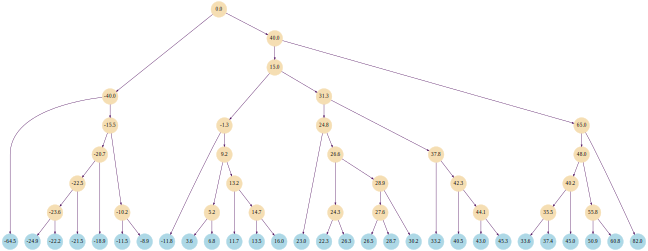

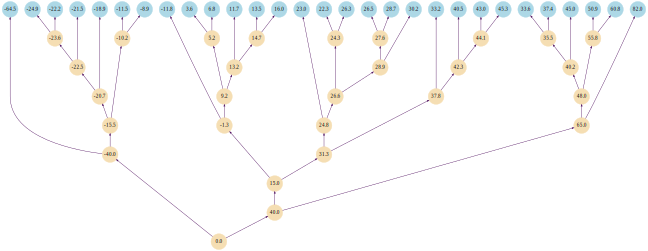

In [98]:
dot.attr(rankdir='TB', size='9,5')
dot2.attr(rankdir='BT', size='9,5')
display(dot)
display(dot2)

In [100]:
dot.source

'digraph {\n\tgraph [rank=flow rankdir=TB]\n\tnode [style=filled]\n\tedge [arrowsize=0.5 fontsize=8.0]\n\t{\n\t\tnode [fixedsize=true height=0.1 label=0.0 style=filled width=0.1]\n\t\tedge [arrowsize=0.5 fontsize=8.0]\n\t\t0 [color=wheat height=0.6 shape=circle width=0.6]\n\t}\n\t{\n\t\tnode [fixedsize=true height=0.1 label=-40.0 style=filled width=0.1]\n\t\tedge [arrowsize=0.5 fontsize=8.0]\n\t\t1 [color=wheat height=0.6 shape=circle width=0.6]\n\t}\n\t0 -> 1 [color="#440154ff"]\n\t{\n\t\tnode [fixedsize=true height=0.1 label=-64.5 style=filled width=0.1]\n\t\tedge [arrowsize=0.5 fontsize=8.0]\n\t\t2 [color=lightblue height=0.6 shape=circle width=0.6]\n\t}\n\t1 -> 2 [color="#440154ff"]\n\t{\n\t\tnode [fixedsize=true height=0.1 label=-15.5 style=filled width=0.1]\n\t\tedge [arrowsize=0.5 fontsize=8.0]\n\t\t3 [color=wheat height=0.6 shape=circle width=0.6]\n\t}\n\t1 -> 3 [color="#440154ff"]\n\t{\n\t\tnode [fixedsize=true height=0.1 label=-20.7 style=filled width=0.1]\n\t\tedge [arrowsiz

# kt algorithm for the 1D exponential shower model

In [31]:
fd1 = open('trees/tree_kt.pkl', "rb")
x_kt= pickle.load(fd1,encoding='latin-1')
fd1.close()

In [32]:
x_kt

{'root_id': 0, 'tree': array([[ 1,  4],
        [ 2,  3],
        [-1, -1],
        [-1, -1],
        [ 5,  6],
        [-1, -1],
        [-1, -1]]), 'content': array([[  0.        ],
        [-40.        ],
        [-42.75272369],
        [-37.24727631],
        [ 40.        ],
        [ 36.8556633 ],
        [ 43.1443367 ]])}

In [33]:
# Recursive function to go deep up to the leaves and then go back to the root adding the children values to get the parent ones

def _rec(jet, parent, node_id, outers_list):

    
    if jet["tree"][node_id, 0] == -1:
        outers.append(jet["content"][node_id])
    else:
        _rec(jet, node_id, jet["tree"][node_id, 0],outers_list)
        _rec(jet, node_id, jet["tree"][node_id, 1],outers_list)

    return outers_list

In [34]:
jet=x_kt
outers=[]
jet_const=np.asarray(_rec(jet, -1, jet["root_id"],outers))

In [35]:
jet_const

array([[-42.75272369],
       [-37.24727631],
       [ 36.8556633 ],
       [ 43.1443367 ]])

In [36]:
def dij(const_list):
    const_list = np.reshape(const_list,len(const_list))
    dijMin=np.inf
    for const in const_list:
        dij=np.sort(np.minimum(const**2,const_list**2)*(const-const_list)**2)
        print(dij)
        print('dij[1] =',dij[1])
        print('==='*4)
        #  We skip the 1st elements, as it corresponds to dii
        if dij[1]<dijMin:
            dijMin=dij[1]
    return dijMin

In [37]:
dij(jet_const)

[       0.            42050.8011747   8608472.81379307 13486031.78660441]
dij[1] = 42050.801174704735
[      0.           42050.8011747  7458978.17297274 8966243.44653697]
dij[1] = 42050.801174704735
[      0.           53718.82989603 7458978.17297274 8608472.81379307]
dij[1] = 53718.829896030766
[       0.            53718.82989603  8966243.44653697 13486031.78660441]
dij[1] = 53718.829896030766


42050.801174704735